In [1]:
# Requirements
# Comment if already satisfied
#!pip install -U jupyter
#!pip install datasets transformers accelerate torch torchinfo xlrd seaborn sklearn torchmetrics
#!pip install --upgrade --quiet jupyter_client ipywidgets
#!jupyter nbextension enable --py widgetsnbextension

This model is the same as the one in `train_classification_model` but the training data no longer has conflicted ADUs.

In [2]:
import os
import pandas as pd

DATA_DIR = "../data/"
LM_DIR = "./out/language_model"
OUT_DIR = "./out/classification_model2"

os.makedirs(OUT_DIR, exist_ok=True)

SEED = 42

In [3]:
import matplotlib.pyplot as plt
def plot_training_history(train_history, val_history, model_name, phase_name, out_dir):
    fig, (loss_ax, acc_ax) = plt.subplots(figsize=(12, 8), nrows=2)
    fig.suptitle(f"{model_name} - {phase_name} History")
    loss_ax.set_title("Cross Entropy Loss")
    loss_ax.plot(train_history["loss"], label="train")
    loss_ax.plot(val_history["loss"], label="val")
    loss_ax.legend(loc="best")

    acc_ax.set_title("Classification accuracy")
    acc_ax.plot(train_history["accuracy"], label="train")
    acc_ax.plot(val_history["accuracy"], label="val")
    loss_ax.legend(loc="best")

    plt.tight_layout()

    fig.savefig(f"{out_dir}/{model_name}_{phase_name}_history.png", dpi=150, bbox_inches='tight')

    return fig

# Load Dataset

In [4]:
#articles = pd.read_excel(os.path.join(DATA_DIR, "OpArticles_ADUs.xlsx"))
adus = pd.read_csv(os.path.join(DATA_DIR, "OpArticles_ADUs.csv")) # If pandas version doesn't support .xlsx, use this instaed

adus.head()

,article_id,annotator,node,ranges,tokens,label
0,5d04a31b896a7fea069ef06f,A,0,"[[2516, 2556]]",O facto não é apenas fruto da ignorância,Value
1,5d04a31b896a7fea069ef06f,A,1,"[[2568, 2806]]",havia no seu humor mais jornalismo (mais inves...,Value
2,5d04a31b896a7fea069ef06f,A,3,"[[3169, 3190]]",É tudo cómico na FIFA,Value
3,5d04a31b896a7fea069ef06f,A,4,"[[3198, 3285]]",o que todos nós permitimos que esta organizaçã...,Value
4,5d04a31b896a7fea069ef06f,A,6,"[[4257, 4296]]",não nos fazem rir à custa dos poderosos,Value


# Check for conflicts on annotations

In [5]:
unique_adus = adus.drop_duplicates(subset=["article_id", "tokens"], keep=False)

print(f"Original dataset shape: {adus.shape} | Unique dataset shape: {unique_adus.shape}")
unique_adus.head()

Original dataset shape: (16743, 6) | Unique dataset shape: (8342, 6)


,article_id,annotator,node,ranges,tokens,label
4,5d04a31b896a7fea069ef06f,A,6,"[[4257, 4296]]",não nos fazem rir à custa dos poderosos,Value
5,5d04a31b896a7fea069ef06f,A,7,"[[4305, 4404]]",alguém os convenceu de que devem ter como crit...,Value
8,5d04a31b896a7fea069ef06f,A,11,"[[3778, 3922]]",toda a comunidade jornalística continua a trat...,Value
9,5d04a31b896a7fea069ef06f,B,0,"[[1321, 1387]]",“o Portugal que morre” morre anónimo e esqueci...,Value(-)
10,5d04a31b896a7fea069ef06f,B,1,"[[1153, 1316]]",Há no discurso político uma tal preocupação co...,Value(-)


In [6]:
duplicated_adus = adus.loc[adus.index.difference(unique_adus.index)].sort_values(by=["article_id", "tokens"])

duplicated_adus

,article_id,annotator,node,ranges,tokens,label
15230,5cdd971b896a7fea062d6e3d,A,23,"[[4683, 4740]]",Esta defesa do indefensável é particularmente ...,Value(-)
15248,5cdd971b896a7fea062d6e3d,B,23,"[[4683, 4740]]",Esta defesa do indefensável é particularmente ...,Value(-)
15260,5cdd971b896a7fea062d6e3d,C,12,"[[4683, 4740]]",Esta defesa do indefensável é particularmente ...,Value(-)
15220,5cdd971b896a7fea062d6e3d,A,5,"[[2467, 2521]]",Já de si isto seria problemático em termos ped...,Value
15239,5cdd971b896a7fea062d6e3d,B,9,"[[2467, 2521]]",Já de si isto seria problemático em termos ped...,Value(-)
...,...,...,...,...,...,...
1957,5d04c671896a7fea06a11275,D,12,"[[1433, 1467]]",Uma coisa é o futebol outra é Deus,Fact
1937,5d04c671896a7fea06a11275,B,2,"[[942, 1097]]",abster-se de participar em órgãos sociais do s...,Value
1955,5d04c671896a7fea06a11275,D,9,"[[942, 1097]]",abster-se de participar em órgãos sociais do s...,Policy
1943,5d04c671896a7fea06a11275,C,0,"[[1376, 1431]]",É completamente descabido misturar religião co...,Value(-)


Label Ratios
Value       0.474227
Fact        0.233158
Value(-)    0.171422
Value(+)    0.083793
Policy      0.037401
Name: label, dtype: float64


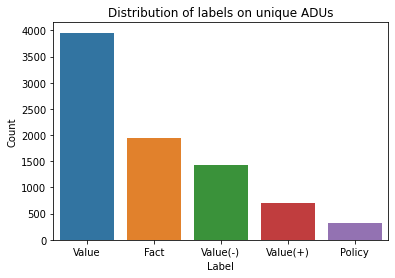

<Figure size 432x288 with 0 Axes>

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

print("Label Ratios")
print(unique_adus["label"].value_counts() / len(unique_adus["label"]))

fig, ax = plt.subplots()
sns.countplot(data=unique_adus, x="label", ax=ax, order=["Value", "Fact", "Value(-)", "Value(+)", "Policy"])
ax.set_title("Distribution of labels on unique ADUs")
ax.set_xlabel("Label")
ax.set_ylabel("Count")
fig.savefig(f"{OUT_DIR}/unique_label_distribution.png", dpi=150, bbox_inches='tight')
plt.show()
plt.clf()

Label Ratios
Value       0.493513
Fact        0.204499
Value(-)    0.174979
Value(+)    0.084752
Policy      0.042257
Name: label, dtype: float64


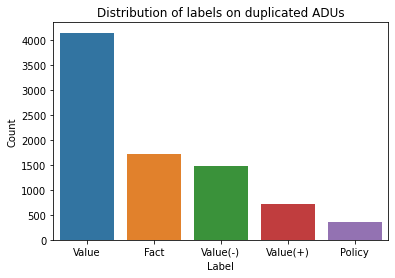

<Figure size 432x288 with 0 Axes>

In [8]:
print("Label Ratios")
print(duplicated_adus["label"].value_counts() / len(duplicated_adus["label"]))

fig, ax = plt.subplots()
sns.countplot(data=duplicated_adus, x="label", ax=ax, order=["Value", "Fact", "Value(-)", "Value(+)", "Policy"])
ax.set_title("Distribution of labels on duplicated ADUs")
ax.set_xlabel("Label")
ax.set_ylabel("Count")
fig.savefig(f"{OUT_DIR}/duplicated_label_distribution.png", dpi=150, bbox_inches='tight')
plt.show()
plt.clf()

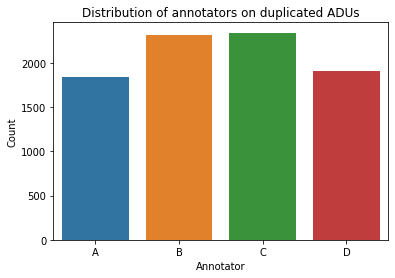

<Figure size 432x288 with 0 Axes>

In [9]:
fig, ax = plt.subplots()
sns.countplot(data=duplicated_adus, x="annotator", ax=ax, order=["A", "B", "C", "D"])
ax.set_title("Distribution of annotators on duplicated ADUs")
ax.set_xlabel("Annotator")
ax.set_ylabel("Count")
fig.savefig(f"{OUT_DIR}/duplicated_annotators_distribution.png", dpi=150, bbox_inches='tight')
plt.show()
plt.clf()

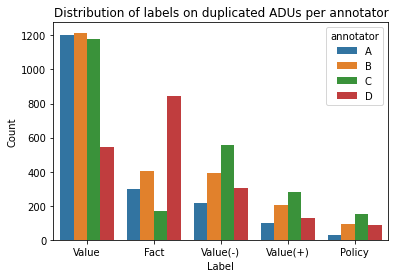

<Figure size 432x288 with 0 Axes>

In [10]:
fig, ax = plt.subplots()
sns.countplot(data=duplicated_adus, x="label", hue="annotator", ax=ax, order=["Value", "Fact", "Value(-)", "Value(+)", "Policy"], hue_order=["A", "B", "C", "D"])
ax.set_title("Distribution of labels on duplicated ADUs per annotator")
ax.set_xlabel("Label")
ax.set_ylabel("Count")
fig.savefig(f"{OUT_DIR}/duplicated_label_distribution_per_annotator.png", dpi=150, bbox_inches='tight')
plt.show()
plt.clf()

# Filter by majority (mode)

In [11]:
modes = duplicated_adus.groupby(by=["article_id", "tokens"])["label"].apply(pd.Series.mode).reset_index(level=2, drop=True).reset_index()
modes

,article_id,tokens,label
0,5cdd971b896a7fea062d6e3d,Esta defesa do indefensável é particularmente ...,Value(-)
1,5cdd971b896a7fea062d6e3d,Já de si isto seria problemático em termos ped...,Value
2,5cdd971b896a7fea062d6e3d,Já de si isto seria problemático em termos ped...,Value(-)
3,5cdd971b896a7fea062d6e3d,a PE parece presumir que em relação a esse per...,Value
4,5cdd971b896a7fea062d6e3d,a ocasião propicia um debate amplo na sociedad...,Value
...,...,...,...
4908,5d04c671896a7fea06a11275,Uma coisa é o futebol outra é Deus,Fact
4909,5d04c671896a7fea06a11275,Uma coisa é o futebol outra é Deus,Value
4910,5d04c671896a7fea06a11275,abster-se de participar em órgãos sociais do s...,Policy
4911,5d04c671896a7fea06a11275,abster-se de participar em órgãos sociais do s...,Value


Check for ADUs with more than one mode

In [12]:
modes[(modes.groupby(by=["article_id", "tokens"]).transform("count") > 1)["label"]]

,article_id,tokens,label
1,5cdd971b896a7fea062d6e3d,Já de si isto seria problemático em termos ped...,Value
2,5cdd971b896a7fea062d6e3d,Já de si isto seria problemático em termos ped...,Value(-)
4,5cdd971b896a7fea062d6e3d,a ocasião propicia um debate amplo na sociedad...,Value
5,5cdd971b896a7fea062d6e3d,a ocasião propicia um debate amplo na sociedad...,Value(+)
11,5cdd971b896a7fea062d6e3d,os autores do livro naturalizam a escravização...,Value
...,...,...,...
4895,5d04c590896a7fea06a0fc78,Carismático,Value(+)
4908,5d04c671896a7fea06a11275,Uma coisa é o futebol outra é Deus,Fact
4909,5d04c671896a7fea06a11275,Uma coisa é o futebol outra é Deus,Value
4910,5d04c671896a7fea06a11275,abster-se de participar em órgãos sociais do s...,Policy


ADUs with one mode only

In [13]:
adus_majority = modes[(modes.groupby(by=["article_id", "tokens"]).transform("count") == 1)["label"]]
adus_majority

,article_id,tokens,label
0,5cdd971b896a7fea062d6e3d,Esta defesa do indefensável é particularmente ...,Value(-)
3,5cdd971b896a7fea062d6e3d,a PE parece presumir que em relação a esse per...,Value
6,5cdd971b896a7fea062d6e3d,basta consultarmos uma fonte incontornável par...,Value
7,5cdd971b896a7fea062d6e3d,ensinar a mentira histórica não é compatível c...,Value
8,5cdd971b896a7fea062d6e3d,esta questão ter [justificadamente] despertado...,Value
...,...,...,...
4904,5d04c590896a7fea06a0fc78,motivador nato,Value(+)
4905,5d04c590896a7fea06a0fc78,verdadeiro,Value(+)
4906,5d04c671896a7fea06a11275,Um presidente de câmara pode pertencer à admin...,Value
4907,5d04c671896a7fea06a11275,Um presidente de câmara pode ter a sua preferê...,Value


Label Ratios
Value       0.534856
Value(-)    0.177083
Fact        0.166667
Value(+)    0.075721
Policy      0.045673
Name: label, dtype: float64


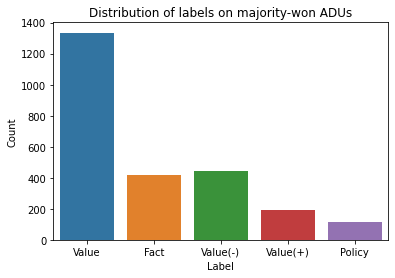

<Figure size 432x288 with 0 Axes>

In [14]:
print("Label Ratios")
print(adus_majority["label"].value_counts() / len(adus_majority["label"]))

fig, ax = plt.subplots()
sns.countplot(data=adus_majority, x="label", ax=ax, order=["Value", "Fact", "Value(-)", "Value(+)", "Policy"])
ax.set_title("Distribution of labels on majority-won ADUs")
ax.set_xlabel("Label")
ax.set_ylabel("Count")
fig.savefig(f"{OUT_DIR}/adus_majority_label_distribution.png", dpi=150, bbox_inches='tight')
plt.show()
plt.clf()

Merge into a single dataset containing only unique ADUs and the ADUs that won by majority

In [15]:
final_adus = pd.concat([unique_adus[["article_id", "tokens", "label"]], adus_majority]).reset_index()

final_adus

,index,article_id,tokens,label
0,4,5d04a31b896a7fea069ef06f,não nos fazem rir à custa dos poderosos,Value
1,5,5d04a31b896a7fea069ef06f,alguém os convenceu de que devem ter como crit...,Value
2,8,5d04a31b896a7fea069ef06f,toda a comunidade jornalística continua a trat...,Value
3,9,5d04a31b896a7fea069ef06f,“o Portugal que morre” morre anónimo e esqueci...,Value(-)
4,10,5d04a31b896a7fea069ef06f,Há no discurso político uma tal preocupação co...,Value(-)
...,...,...,...,...
10833,4904,5d04c590896a7fea06a0fc78,motivador nato,Value(+)
10834,4905,5d04c590896a7fea06a0fc78,verdadeiro,Value(+)
10835,4906,5d04c671896a7fea06a11275,Um presidente de câmara pode pertencer à admin...,Value
10836,4907,5d04c671896a7fea06a11275,Um presidente de câmara pode ter a sua preferê...,Value


Label Ratios
Value       0.488190
Fact        0.217845
Value(-)    0.172726
Value(+)    0.081934
Policy      0.039306
Name: label, dtype: float64


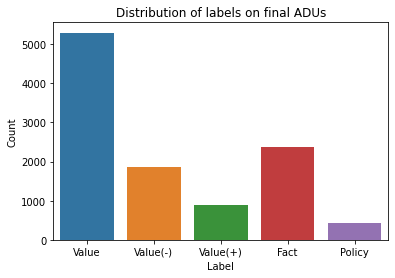

<Figure size 432x288 with 0 Axes>

In [16]:
print("Label Ratios")
print(final_adus["label"].value_counts() / len(final_adus["label"]))

fig, ax = plt.subplots()
sns.countplot(data=final_adus, x="label", ax=ax)
ax.set_title("Distribution of labels on final ADUs")
ax.set_xlabel("Label")
ax.set_ylabel("Count")
fig.savefig(f"{OUT_DIR}/final_label_distribution_full.png", dpi=150, bbox_inches='tight')
plt.show()
plt.clf()

Encode Labels

In [17]:
classes = ["Fact", "Policy", "Value", "Value(+)", "Value(-)"]
N_CLASSES = len(classes)
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
final_adus["label"] = le.fit_transform(final_adus["label"])

final_adus

,index,article_id,tokens,label
0,4,5d04a31b896a7fea069ef06f,não nos fazem rir à custa dos poderosos,2
1,5,5d04a31b896a7fea069ef06f,alguém os convenceu de que devem ter como crit...,2
2,8,5d04a31b896a7fea069ef06f,toda a comunidade jornalística continua a trat...,2
3,9,5d04a31b896a7fea069ef06f,“o Portugal que morre” morre anónimo e esqueci...,4
4,10,5d04a31b896a7fea069ef06f,Há no discurso político uma tal preocupação co...,4
...,...,...,...,...
10833,4904,5d04c590896a7fea06a0fc78,motivador nato,3
10834,4905,5d04c590896a7fea06a0fc78,verdadeiro,3
10835,4906,5d04c671896a7fea06a11275,Um presidente de câmara pode pertencer à admin...,2
10836,4907,5d04c671896a7fea06a11275,Um presidente de câmara pode ter a sua preferê...,2


# Create Train, Validation and Test splits

Train Label Ratios
Value       0.488178
Fact        0.217849
Value(-)    0.172722
Value(+)    0.081892
Policy      0.039360
dtype: float64
Validation Label Ratios
Value       0.488184
Fact        0.217867
Value(-)    0.172911
Value(+)    0.081844
Policy      0.039193
dtype: float64
Test Label Ratios
Value       0.488233
Fact        0.217813
Value(-)    0.172589
Value(+)    0.082141
Policy      0.039225
dtype: float64


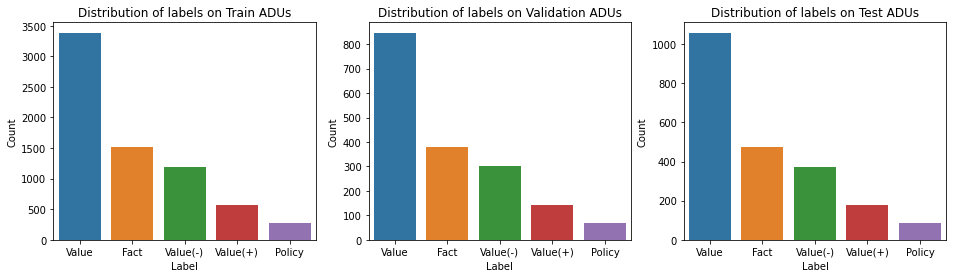

<Figure size 432x288 with 0 Axes>

In [18]:
# Maintain the ratios of labels across splits
train_val_adus = final_adus.groupby("label").sample(frac=0.8, random_state=SEED)
test_adus = final_adus.loc[final_adus.index.difference(train_val_adus.index)]

train_adus = train_val_adus.groupby("label").sample(frac=0.8, random_state=SEED)
val_adus = train_val_adus.loc[train_val_adus.index.difference(train_adus.index)]

fig, (train_ax, val_ax, test_ax) = plt.subplots(figsize=(16, 4), ncols=3)
for split, df, ax in zip(["Train", "Validation", "Test"], [train_adus, val_adus, test_adus], [train_ax, val_ax, test_ax]):
    df_labels = le.inverse_transform(df["label"])
    sns.countplot(x=df_labels, ax=ax, order=["Value", "Fact", "Value(-)", "Value(+)", "Policy"])
    ax.set_title(f"Distribution of labels on {split} ADUs")
    ax.set_xlabel("Label")
    ax.set_ylabel("Count")
    
    print(f"{split} Label Ratios")
    print(pd.Series(df_labels).value_counts() / len(df_labels))
fig.savefig(f"{OUT_DIR}/label_distribution_splits.png", dpi=150, bbox_inches='tight')
plt.show()
plt.clf()

In [19]:
train_adus

,index,article_id,tokens,label
2820,5684,5cf46b97896a7fea0600233c,"A Lei, contudo, é cega e igual para todos",0
10674,4566,5d04be5c896a7fea06a07cba,"não se pode legislar por resoluções, sejam do ...",0
3352,6708,5cf4665e896a7fea06ffd932,"em 2012, havia “despesa efectiva” e “despesa e...",0
8766,827,5cf45c2c896a7fea06ff3e2a,O índice de envelhecimento e de dependência de...,0
4223,8436,5cf463d6896a7fea06ffb4a8,na verdade não ser inteiramente de raiz,0
...,...,...,...,...
3742,7533,5cf4650f896a7fea06ffbe46,"Dez anos depois da crise, o mercado de trabalh...",4
9121,1436,5cf45f5e896a7fea06ff68c2,ser uma leviandade reputarem-se estes gastos d...,4
436,813,5d04be5c896a7fea06a07cba,"é, a meu ver, um aborto ortográfico",4
7229,14472,5cf45b77896a7fea06ff28ff,"derrapando, aos empurrões, para um proteccioni...",4


# Convert Dataset to HF Dataset

In [20]:
from datasets.dataset_dict import DatasetDict
from datasets import Dataset, DatasetInfo, Features, Value, ClassLabel
info = DatasetInfo(
    features=Features({
        "index": Value("int64"),
        "tokens": Value("string"),
        "label": ClassLabel(num_classes=N_CLASSES, names=le.classes_.tolist()),
        "article_id": Value("string"),
    })
)

adus_dataset = DatasetDict({
    "train": Dataset.from_pandas(train_adus, preserve_index=True, info=info),
    "val": Dataset.from_pandas(val_adus, preserve_index=True, info=info),
    "test": Dataset.from_pandas(test_adus, preserve_index=True, info=info)
})

print(adus_dataset)

DatasetDict({
    train: Dataset({
        features: ['index', 'tokens', 'label', 'article_id'],
        num_rows: 6936
    })
    val: Dataset({
        features: ['index', 'tokens', 'label', 'article_id'],
        num_rows: 1735
    })
    test: Dataset({
        features: ['index', 'tokens', 'label', 'article_id'],
        num_rows: 2167
    })
})


In [21]:
adus_dataset["train"].features

{'index': Value(dtype='int64', id=None),
 'tokens': Value(dtype='string', id=None),
 'label': ClassLabel(num_classes=5, names=['Fact', 'Policy', 'Value', 'Value(+)', 'Value(-)'], id=None),
 'article_id': Value(dtype='string', id=None)}

Base Tokenizer

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('neuralmind/bert-large-portuguese-cased', do_lower_case=True)

In [ ]:
def tokenize(batch):
    result = tokenizer(batch["tokens"])
    return result

In [ ]:
cls_dataset = adus_dataset.map(
    tokenize, batched=True, remove_columns=["article_id", "tokens"]
)

print(cls_dataset)

# Define Dataloaders

In [ ]:
from transformers import DataCollatorWithPadding
from torch.utils.data import DataLoader

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")

BATCH_SIZE = 64 # Tested with NVIDIA Tesla T4 16GB
train_dataloader = DataLoader(
    dataset=cls_dataset["train"],
    shuffle=True,
    batch_size=BATCH_SIZE,
    collate_fn=data_collator
)

val_dataloader = DataLoader(
    dataset=cls_dataset["val"],
    shuffle=False,
    batch_size=BATCH_SIZE,
    collate_fn=data_collator
)

test_dataloader = DataLoader(
    dataset=cls_dataset["test"],
    shuffle=False,
    batch_size=1,
    collate_fn=data_collator
)

# Model Definition

In [ ]:
from transformers import AutoModelForSequenceClassification
from torchinfo import summary

model = AutoModelForSequenceClassification.from_pretrained(f"{LM_DIR}/best", num_labels=N_CLASSES)

summary(model)

# Define Optimizer

In [ ]:
from torch import optim

optimizer = optim.Adam(
    params=model.parameters(),
    lr=5e-3,
    betas=(0.9, 0.999),
    weight_decay=1e-4,
    amsgrad=True
)

# Prepare Classification Model

In [ ]:
from accelerate import Accelerator

accelerator = Accelerator()

model, optimizer, train_dataloader, val_dataloader = accelerator.prepare(
    model, optimizer, train_dataloader, val_dataloader
)

# Define Epoch Iteration

In [ ]:
import json
synonyms = {}

with open(DATA_DIR + "/synonyms.json", "r", encoding="utf-8") as synonyms_json:
    synonyms = json.load(synonyms_json)

synonyms_tokenized = {}
n = 0
for k, v in synonyms.items():
    tokens_k = tokenizer.encode(k, add_special_tokens=False)

    # Don't allow multi token for simplicity
    if len(tokens_k) > 1:
        continue

    token_v = [tokenizer.encode(s, add_special_tokens=False) for s in v]
    token_v = [tv[0] for tv in token_v if len(tv) == 1]

    if token_v:
        synonyms_tokenized[tokens_k[0]] = token_v

    
def add_synonyms(input_ids, p = 0.05):
    for i in range(len(input_ids)):
        inputId = input_ids[i].item()
        if (inputId in synonyms_tokenized) and np.random.binomial(1, p):
            input_ids[i] = np.random.choice(synonyms_tokenized[inputId])

In [ ]:
import torch
import torch.nn.functional as F
from tqdm import tqdm
import numpy as np

def epoch_iter(dataloader, model, is_train = True, optimizer=None, lr_scheduler=None):
    if is_train:
        assert optimizer is not None, "When training, please provide an optimizer."
      
    num_batches = len(dataloader)

    if is_train:
        model.train()
    else:
        model.eval()

    total_loss = 0.0
    probs = []
    preds = []
    expected_labels = []
    aduIds = []
    
    scaler = torch.cuda.amp.GradScaler()

    with torch.set_grad_enabled(is_train):
        for batch in tqdm(dataloader):
            index = batch.pop("index")

            if is_train:
                for b_input_ids in batch["input_ids"]:
                    add_synonyms(b_input_ids, p=0.3)
            
            with torch.cuda.amp.autocast():
                outputs = model(**batch)
            loss = outputs.loss

            if is_train:
                optimizer.zero_grad()
                accelerator.backward(scaler.scale(loss))
                scaler.step(optimizer)
                scaler.update()
            
            total_loss += loss.item()

            prob = F.softmax(outputs.logits, dim=1)
            final_pred = torch.argmax(prob, dim=1)

            aduIds.extend(index.detach().cpu().numpy())
            probs.extend(prob.detach().cpu().numpy())
            preds.extend(final_pred.detach().cpu().numpy())
            expected_labels.extend(batch["labels"].detach().cpu().numpy())
            
        if is_train and lr_scheduler is not None:
            lr_scheduler.step()
        
    return (expected_labels, preds, probs, aduIds), total_loss / num_batches


# Train Classification Model

In [ ]:
from torch import optim
import torchmetrics

NUM_EPOCHS = 30

lr_scheduler = optim.lr_scheduler.ExponentialLR(
    optimizer=optimizer,
    gamma=0.9,
    verbose=True
)

metric_scorer = torchmetrics.Accuracy(
    threshold=0.5,
    num_classes=N_CLASSES,
    average="micro",
)

In [ ]:
train_history = {
    "loss": [],
    "accuracy": []
}

val_history = {
    "loss": [],
    "accuracy": []
}

model.bert.requires_grad_(False) # Freeze language model layer

best_loss = np.inf
best_accuracy = 0
best_epoch = -1

print(f"Starting classification language model training...")

for epoch in range(1, NUM_EPOCHS + 1):
    print(f"Epoch[{epoch}/{NUM_EPOCHS}]")
    
    (train_target, train_preds, train_probs, _), train_loss = epoch_iter(
        dataloader=train_dataloader,
        model=model,
        is_train=True,
        optimizer=optimizer,
        lr_scheduler=lr_scheduler
    )
    
    train_accuracy = metric_scorer(torch.tensor(np.array(train_probs)), torch.tensor(np.array(train_target))).item()
    print(f"Training loss: {train_loss:.3f}\t Training micro accuracy: {train_accuracy:.3f}")

    (val_target, val_preds, val_probs, _), val_loss = epoch_iter(
        dataloader=val_dataloader,
        model=model,
        is_train=False,
    )

    val_accuracy = metric_scorer(torch.tensor(np.array(val_probs)), torch.tensor(np.array(val_target))).item()
    print(f"Validation loss: {val_loss:.3f}\t Validation micro accuracy: {val_accuracy:.3f}")
    
    # Save best model
    if val_loss < best_loss:
        best_loss = val_loss
        best_accuracy = val_accuracy
        best_epoch = epoch
        
        accelerator.wait_for_everyone()
        unwrapped_model = accelerator.unwrap_model(model)
        unwrapped_model.save_pretrained(f"{OUT_DIR}/best", save_function=accelerator.save)

    accelerator.wait_for_everyone()
    unwrapped_model = accelerator.unwrap_model(model)
    unwrapped_model.save_pretrained(f"{OUT_DIR}/latest", save_function=accelerator.save)

    train_history["loss"].append(train_loss)
    train_history["accuracy"].append(train_accuracy)

    val_history["loss"].append(val_loss)
    val_history["accuracy"].append(val_accuracy)

    print("----------------------------------------------------------------")
    
print(
    f"\nFinished training..."
    f"\nBest epoch: {best_epoch}\t Validation loss on best epoch: {best_loss}\t Accuracy on best epoch: {best_accuracy}"
)

In [ ]:
fig = plot_training_history(train_history=train_history, val_history=val_history, model_name="BERT-ADU-CLS", phase_name="FREEZE", out_dir=OUT_DIR)
fig.show()

Clear GPU memory for guarantees

In [ ]:
import gc
model = None
train_dataloader = None
val_dataloader = None
lr_scheduler = None
optimizer = None

gc.collect()
torch.cuda.empty_cache()
torch.cuda.mem_get_info("cuda:0")

In [ ]:
!nvidia-smi

# Fine-tune model
Load best model from first training session

In [ ]:
from transformers import DataCollatorWithPadding
from torch.utils.data import DataLoader

BATCH_SIZE = 16 # Tested with NVIDIA Tesla T4 16GB

train_dataloader = DataLoader(
    dataset=cls_dataset["train"],
    shuffle=True,
    batch_size=BATCH_SIZE,
    collate_fn=data_collator
)

val_dataloader = DataLoader(
    dataset=cls_dataset["val"],
    shuffle=False,
    batch_size=BATCH_SIZE,
    collate_fn=data_collator
)

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(f"{OUT_DIR}/best", num_labels=N_CLASSES)

print("Loaded best model...")

summary(model)

In [ ]:
ft_optimizer = optim.Adam(
    params=model.parameters(),
    lr=1e-5,
    betas=(0.9, 0.999),
    weight_decay=5e-4,
    amsgrad=True
)

accelerator = Accelerator()

model, ft_optimizer, train_dataloader, val_dataloader = accelerator.prepare(
    model, ft_optimizer, train_dataloader, val_dataloader
)

ft_lr_scheduler = optim.lr_scheduler.ExponentialLR(
    optimizer=ft_optimizer,
    gamma=0.9,
    verbose=True
)

In [ ]:
ft_train_history = {
    "loss": [],
    "accuracy": []
}

ft_val_history = {
    "loss": [],
    "accuracy": []
}

FT_NUM_EPOCHS = 15
model.bert.requires_grad_(True) # Unfreeze language model layer

ft_best_loss = best_loss 
ft_best_accuracy = best_accuracy
ft_best_epoch = -1

print(f"Starting classification language model fine-tuning...")

for epoch in range(1, FT_NUM_EPOCHS + 1):
    print(f"Epoch[{epoch}/{FT_NUM_EPOCHS}]")
    
    (train_target, train_preds, train_probs, _), train_loss = epoch_iter(
        dataloader=train_dataloader,
        model=model,
        is_train=True,
        optimizer=ft_optimizer,
        lr_scheduler=ft_lr_scheduler
    )
    
    train_accuracy = metric_scorer(torch.tensor(np.array(train_probs)), torch.tensor(np.array(train_target))).item()
    print(f"Training loss: {train_loss:.3f}\t Training micro accuracy: {train_accuracy:.3f}")

    (val_target, val_preds, val_probs, _), val_loss = epoch_iter(
        dataloader=val_dataloader,
        model=model,
        is_train=False,
    )

    val_accuracy = metric_scorer(torch.tensor(np.array(val_probs)), torch.tensor(np.array(val_target))).item()
    print(f"Validation loss: {val_loss:.3f}\t Validation micro accuracy: {val_accuracy:.3f}")
    
    # Save best model
    if val_loss < ft_best_loss:
        ft_best_loss = val_loss
        ft_best_accuracy = val_accuracy
        ft_best_epoch = epoch
        
        accelerator.wait_for_everyone()
        unwrapped_model = accelerator.unwrap_model(model)
        unwrapped_model.save_pretrained(f"{OUT_DIR}/fine_tuned/best", save_function=accelerator.save)

    accelerator.wait_for_everyone()
    unwrapped_model = accelerator.unwrap_model(model)
    unwrapped_model.save_pretrained(f"{OUT_DIR}/fine_tuned/latest", save_function=accelerator.save)

    ft_train_history["loss"].append(train_loss)
    ft_train_history["accuracy"].append(train_accuracy)

    ft_val_history["loss"].append(val_loss)
    ft_val_history["accuracy"].append(val_accuracy)

    print("----------------------------------------------------------------")
    
print(
    f"\nFinished fine-tuning..."
    f"\nBest epoch: {ft_best_epoch}\t Validation loss on best epoch: {ft_best_loss}\t Accuracy on best epoch: {ft_best_accuracy}"
)

In [ ]:
fig = plot_training_history(train_history=ft_train_history, val_history=ft_val_history, model_name="BERT-ADU-CLS", phase_name="FINE-TUNE", out_dir=OUT_DIR)
fig.show()

In [ ]:
import gc
model = None

gc.collect()
torch.cuda.empty_cache()
torch.cuda.mem_get_info("cuda:0")

In [ ]:
!nvidia-smi

# Test the model

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(f"{OUT_DIR}/fine_tuned/best", num_labels=N_CLASSES)

print("Loaded best fine-tuned model...")

summary(model)

In [ ]:
accelerator = Accelerator()

model, test_dataloader = accelerator.prepare(model, test_dataloader)

In [ ]:
(test_target, test_preds, test_probs, test_ids), test_loss = epoch_iter(
    dataloader=test_dataloader,
    model=model,
    is_train=False,
)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true=test_target, y_pred=test_preds, target_names=le.classes_.tolist()))

In [ ]:
def getErrors(adu_dataframe, adu_ids, y_true, y_pred):
    df = pd.DataFrame(columns=["id", "adu", "target", "predicted"])
    for (aduId, correct, predicted) in zip(adu_ids, y_true, y_pred):
        if correct == predicted:
            continue
        row = {
            "id": aduId,
            "adu": adu_dataframe.iloc[aduId]["tokens"],
            "target": correct,
            "predicted": predicted
        }
        
        df = df.append(row, ignore_index=True)
    return df

errors_df = getErrors(final_adus, test_ids, le.inverse_transform(test_target), le.inverse_transform(test_preds))
errors_df

In [ ]:
errors_df.to_csv(f"{OUT_DIR}/test_errors.csv", index=False)